In [1]:
%cd ../..

c:\Users\abdul\Desktop\TUM\thesis\thesis


In [4]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from matplotlib import patches, pyplot as plt
import json

from src.efficientnet.keras import EfficientNetB0, EfficiUNetB0

def load_model(path: str):
    baseModel = EfficientNetB0(weights=None, include_top=False, input_shape=(None,None,3))
    model = EfficiUNetB0(baseModel, seg_maps=1, seg_act='sigmoid')
    model.load_weights(path)
    return model

def load_tiger_image(image_id: int, path: str):
    with open(os.path.join(path, "tiger-coco.json"), 'r') as f:
        annotations = json.load(f)
    image_name = os.path.basename(annotations["images"][image_id]["file_name"])
    image = np.array(Image.open(os.path.join(path, "images", image_name)))
    bboxes = [  # bounding boxes for lymphocytes and plasma cells
        item for item in annotations["annotations"] 
        if item["image_id"] is image_id
    ]
    return image, bboxes

def transform_image(image: np.ndarray) -> tf.Tensor:
    transformed_image = tf.convert_to_tensor(image / 255., dtype=float) 
    transformed_image -= tf.convert_to_tensor([0.485, 0.456, 0.406], dtype=float)
    transformed_image /=  tf.convert_to_tensor([0.229, 0.224, 0.225], dtype=float)
    return tf.expand_dims(transformed_image, axis=0)
    
def inference(model, image: np.ndarray):
    return np.array(model.predict_on_batch(tf.convert_to_tensor(image)))

In [5]:
# load tiger data
image, bboxes = load_tiger_image(16, os.path.join("..", "tiger_fork", "tiger data"))
for bbox in bboxes:
    bbox["bbox"][0] -= image.shape[1] - 128
    bbox["bbox"][1] -= image.shape[0] - 128
image = image[-128:, -128:, :]

# load released models
models = [
    load_model(os.path.join("weights", model))
    for model in os.listdir("weights")
]

# inference 
model_input = transform_image(image)
segmentation = sum([inference(model, model_input)[0, :, :, 0] for model in models]) / 3

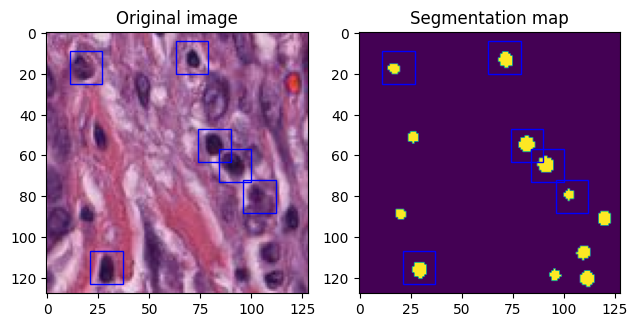

In [6]:
# display inference results

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(image)
axes[0].set_title("Original image")
axes[1].imshow(segmentation > 0.3)
axes[1].set_title("Segmentation map")
for ax in axes:
    for bbox in bboxes:
        x, y, w, h = bbox["bbox"]
        ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='b', facecolor='none'))
plt.tight_layout()
plt.show()